#  Predicting cpu/event

We use linear model and fit separately for each production task.  
Features we use:
  * CPU name
  * input size in kb/event.
  * is VM
  * is Hyperthreaded
  
If there is not enough measurements for a CPU type we use mean value (equivalent of dummy regressor).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, TheilSenRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


In [2]:
LReg = LinearRegression() 
#LReg.fit_intercept=False
LReg_name="linear_regression"

# LReg = Ridge(alpha = .5)
# LReg_name="ridge"

Ltsr=TheilSenRegressor()

### Get datasets

In [3]:
jobs = pd.DataFrame()
input_files=['job_node_info.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file))
jobs = pd.concat(tmp)

jobs = jobs[jobs['nevents']>20]
jobs = jobs[jobs['inputsize']>1024]

jobs['kBperEvent']= (jobs['inputsize']/1024.)/jobs['nevents']
del jobs['cputime']
del jobs['walltime']
del jobs['nevents']
del jobs['cpueff']
del jobs['wallPerEvent']
del jobs['inputsize']

jobs.head()

,host,processingtype,cpuPerEvent,taskid,kBperEvent
1,td113.pic.es,recon,85.896000,11470165,4013.824289
2,b63ab874b9.cern.ch,simul,45.890000,11374294,206.843824
3,t2-wn-91.mi.infn.it,pmerge,0.642599,11570096,198.778945
5,b6bd945e9b.cern.ch,recon,21.091304,11449385,1161.018920
6,wn1908201.in.tier2.hep.manchester.ac.uk,evgen,986.180000,11173045,419.574004


In [4]:
input_files=['benchmark_node_info.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file))
benchmarks = pd.concat(tmp)

print(benchmarks.columns)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

#print(benchmarks.columns)

benchmarks.head()

Index(['ip', 'host', 'site', 'meminfo', 'mpnum', 'cpuname', 'VM', 'cpunum',
       'coresPerSocket', 'threadsPerCore'],
      dtype='object')


,host,mpnum,cpuname,VM,cpunum,coresPerSocket,threadsPerCore
0,r25-n14.ph.liv.ac.uk,1,Intel(R) Xeon(R) CPU E5-2630 v2 @ 2.60GHz,False,24,6,2
1,cern-atlas-dcb8d293-709a-42f5-b891-8f3eface243...,8,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,True,8,1,1
2,wn-200-03-27-01-a.cr.cnaf.infn.it,8,AMD Opteron(tm) Processor 6320,False,16,4,2
3,wg60.grid.hep.ph.ic.ac.uk,8,Intel(R) Xeon(R) CPU X5650 @ 2.67GHz,False,24,6,2
4,vac037-03.beowulf.cluster,1,QEMU Virtual CPU version 1.5.3,True,8,1,1


#### make new CPU name that adds "VM" and "HT" if needed

In [5]:
def getCPU(cpu,vm,tpc):
    res=cpu.strip()
    if tpc>1: res+=" HT"
    if vm: res+=" VM"
    return res
benchmarks['CPU'] = benchmarks.apply(lambda x: getCPU(x['cpuname'], x['VM'], x['threadsPerCore']), axis=1)
del benchmarks['cpuname']
del benchmarks['VM']
del benchmarks['coresPerSocket']
del benchmarks['threadsPerCore']
del benchmarks['mpnum']
del benchmarks['cpunum']
benchmarks=benchmarks.set_index('host')
benchmarks.head()

,CPU
host,
r25-n14.ph.liv.ac.uk,Intel(R) Xeon(R) CPU E5-2630 v2 @ 2.60GHz HT
cern-atlas-dcb8d293-709a-42f5-b891-8f3eface243c.cern.ch,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz VM
wn-200-03-27-01-a.cr.cnaf.infn.it,AMD Opteron(tm) Processor 6320 HT
wg60.grid.hep.ph.ic.ac.uk,Intel(R) Xeon(R) CPU X5650 @ 2.67GH...
vac037-03.beowulf.cluster,QEMU Virtual CPU version 1.5.3 VM


### join dataframes and filter out unneded rows

In [6]:
jobs['CPU']=(jobs['host']).map(benchmarks['CPU'])
del jobs['host']

jobs = jobs[jobs.processingtype != 'digit']
jobs = jobs[jobs.processingtype != 'validation']
jobs = jobs[jobs.processingtype != 'skim']
jobs = jobs[jobs.processingtype != 'overlay']
jobs = jobs[jobs.processingtype != 'eventindex']

#jobs.CPU=jobs.processingtype
jobs.head()

# benchmarks = benchmarks[benchmarks.cpuPerMB > 0]
# benchmarks = benchmarks[benchmarks.cpuPerEvent > 0]

,processingtype,cpuPerEvent,taskid,kBperEvent,CPU
1,recon,85.896000,11470165,4013.824289,Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz HT
2,simul,45.890000,11374294,206.843824,Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz VM
3,pmerge,0.642599,11570096,198.778945,AMD Opteron(tm) Processor 6320 HT
5,recon,21.091304,11449385,1161.018920,Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz VM
6,evgen,986.180000,11173045,419.574004,Intel(R) Xeon(R) CPU X5650 @ 2.67GH...


### split over different processing types 

In [7]:
UniqueProcessingTypes = jobs.processingtype.unique()
print(UniqueProcessingTypes)
UniqueProcessingTypes=UniqueProcessingTypes.tolist()

#UniqueProcessingTypes.remove('overlay') # only 46 measurements
#UniqueProcessingTypes.remove('deriv') #

#create a dict for all the dataframes to be filled later
ProcessingType = {elem : pd.DataFrame for elem in UniqueProcessingTypes}

#filling up data frames
for key in ProcessingType.keys():
    ProcessingType[key] = jobs[:][jobs.processingtype == key]
    

['recon' 'simul' 'pmerge' 'evgen' 'deriv' 'merge' 'pile' 'reprocessing']


#### helpful functions

In [8]:
def correlationPlot(x1=[],y1=[],x2=[],y2=[],x3=[],y3=[],xt="x",yt="y", tit="", fit=True):
#     print ("test:",x1,y1)
#     print ("test_prediction:",x2,y2)
#     print ("Train:", x3.flatten().tolist(),y3.flatten().tolist())
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax1 = fig.add_subplot(111)
    sec = ax1.scatter(x3.flatten().tolist(), y3.flatten().tolist(), label='train',c='b')
    scp = ax1.scatter(x1, y1, label='test', c='g')
    scp = ax1.scatter(x2, y2, label='test_prediction', marker="s",c='r')
    plt.xlabel(xt)
    plt.ylabel(yt)
    plt.title(tit)
    plt.legend()
    if fit:
        lm = LReg.fit(x3, y3)
        print ("Linear model:",lm.coef_ , lm.intercept_)
        
        x_fit = np.linspace(x3[0], x3[-1], 2)
        y_fit = x_fit * lm.coef_[0][0] + lm.intercept_
        
        ax1.plot(x_fit, y_fit,'-', color='red')
        

### split on training and testing samples

========================  pmerge ==============================
- Intel(R) Xeon(R) CPU E5-2650 0 @ 2.00GHz HT -
good fit: 0.323188521561
- Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz VM -
good fit: 0.0152623944194
- Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz HT -
Bad fit, using mean.  -0.110987418324 [[ 0.00519714]] [-0.33356449]
- Intel(R) Xeon(R) CPU E5-2683 v4 @ 2.10GHz -
good fit: 0.0500366803902
- AMD Opteron(TM) Processor 6234 HT -
good fit: 0.179158049713
- Intel(R) Xeon(R) CPU           X5650  @ 2.67GHz HT -
good fit: 0.152422915321
- AMD Opteron(TM) Processor 6238 HT -
good fit: 0.173536562613
- Dual-Core AMD Opteron(tm) Processor 2216 -
good fit: 0.427646304362
- Intel(R) Xeon(R) CPU            5160  @ 3.00GHz -
good fit: 0.753201421176
- Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz HT -
good fit: 0.213421862386
- Intel(R) Xeon(R) CPU E5-2620 0 @ 2.00GHz -
good fit: 0.859466476701
- Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz HT -
good fit: 0.189867396298
- Intel(R) Xeon(R) CPU E5-26

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Linear model: [[ -2.40932096e-05]] [ 0.47811576]
- Intel(R) Xeon(R) CPU E5-2665 0 @ 2.40GHz -
Not enough data. Using mean value.
- Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz VM -
Not enough data. Using mean value.
- Intel(R) Xeon(R) CPU           E5520  @ 2.27GHz HT -
Bad fit, using mean.  -0.00041520064301 [[ -2.05729030e-05]] [ 1.15730434]
Linear model: [[ -2.05729030e-05]] [ 1.15730434]
- AMD FX(tm)-8350 Eight-Core Processor HT -
Not enough data. Using mean value.
- Intel(R) Xeon(R) CPU E5-2690 v4 @ 2.60GHz HT -
good fit: 0.0444169146853
- Six-Core AMD Opteron(tm) Processor 2431 -
good fit: 0.60507295742
- Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz -
good fit: 0.651671992025
- Intel(R) Core(TM)2 Quad CPU    Q8300  @ 2.50GHz -
Bad fit, using mean.  -0.0168717233622 [[ 0.00011235]] [ 1.35409693]
Linear model: [[ 0.00011235]] [ 1.35409693]
- Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz VM -
good fit: 0.703594438186
- Intel(R) Xeon(R) CPU           E5450  @ 3.00GHz -
Bad fit, using mean.  -0

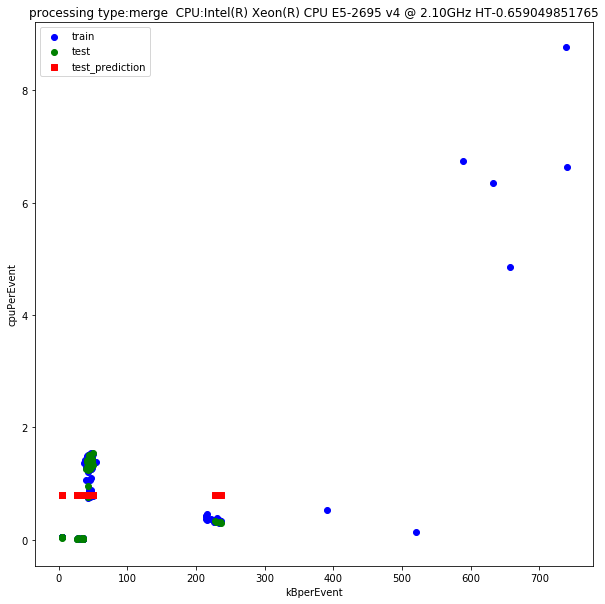

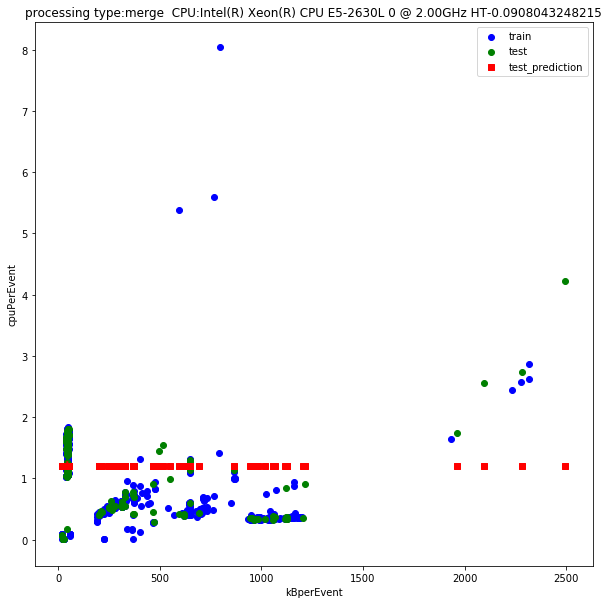

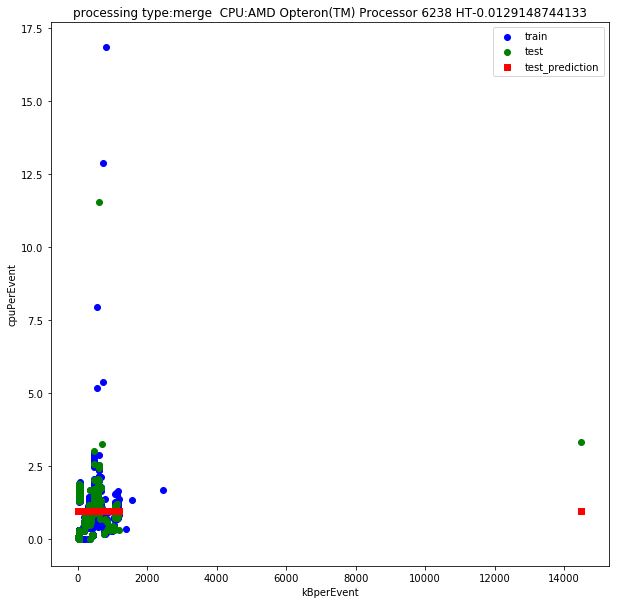

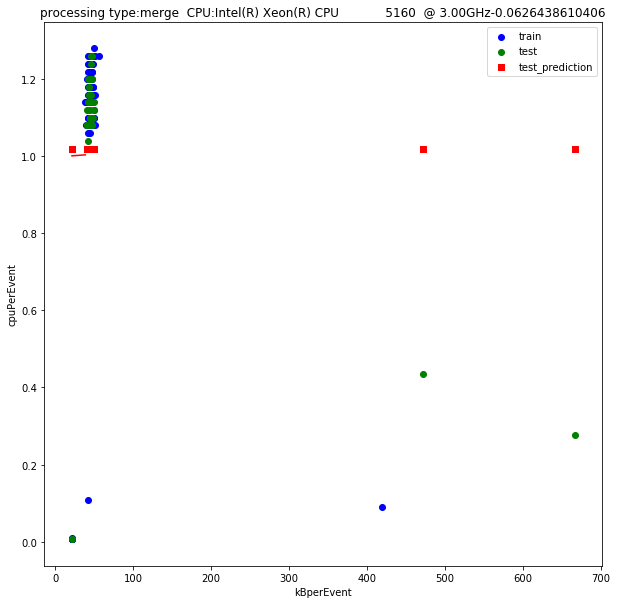

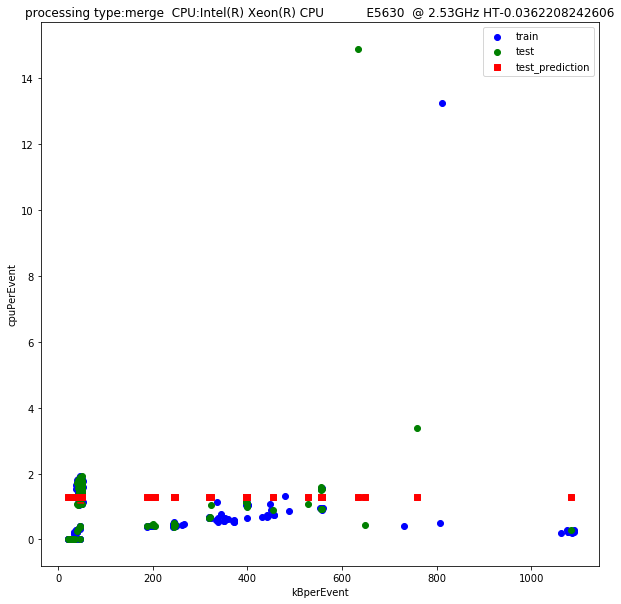

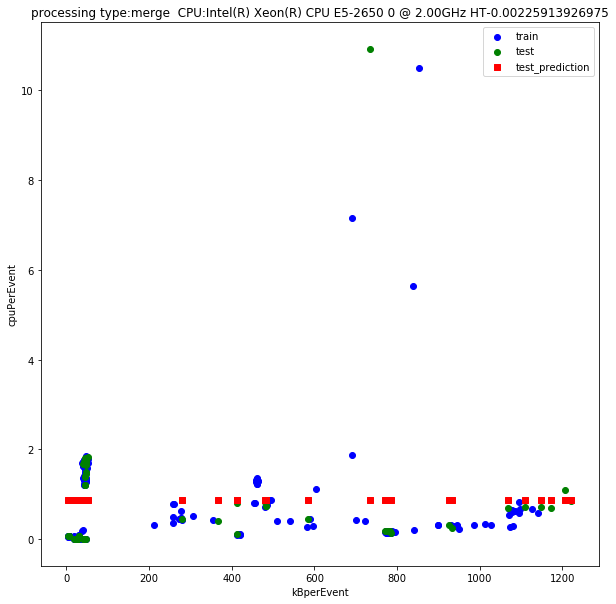

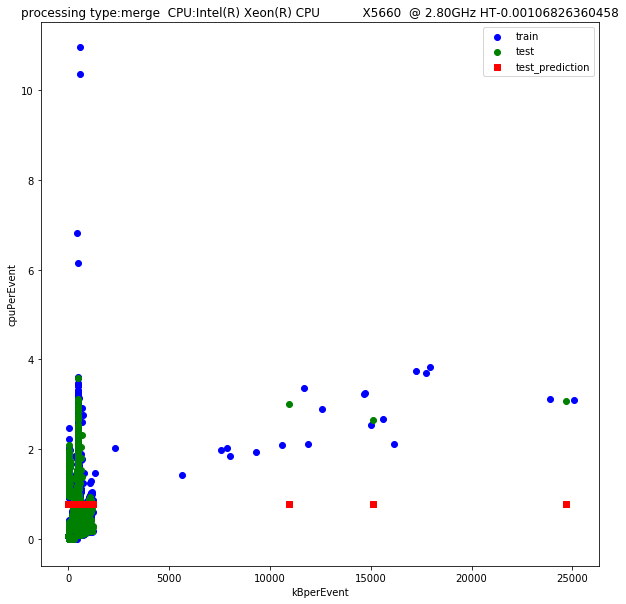

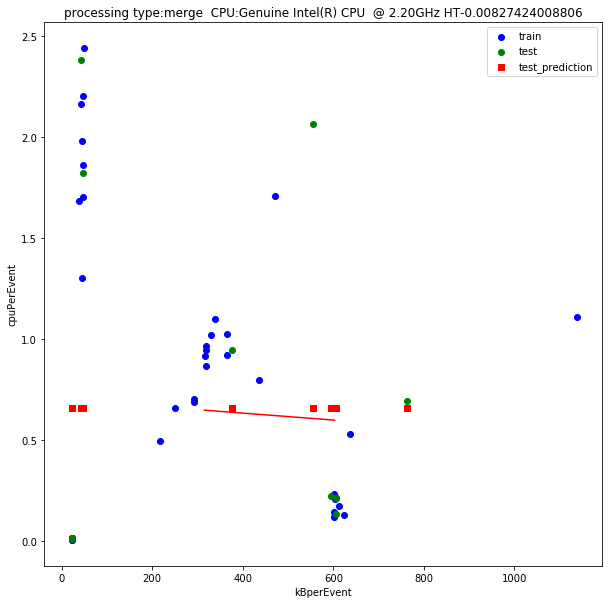

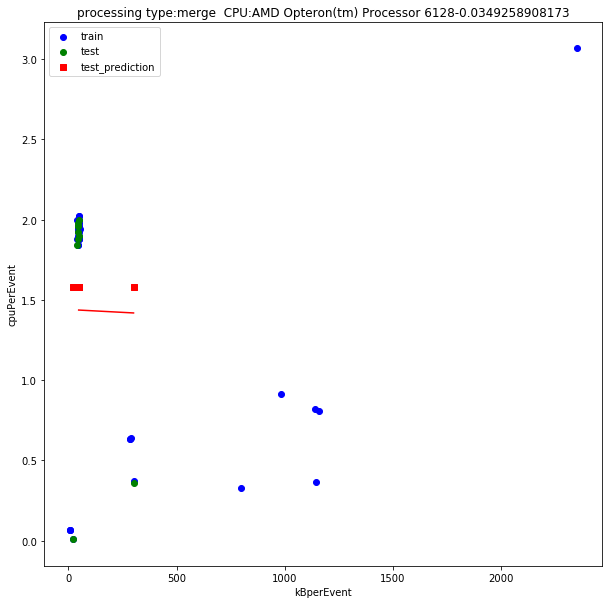

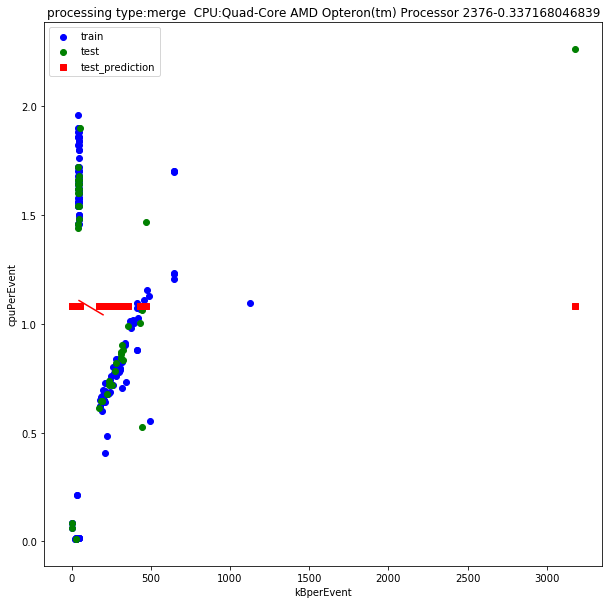

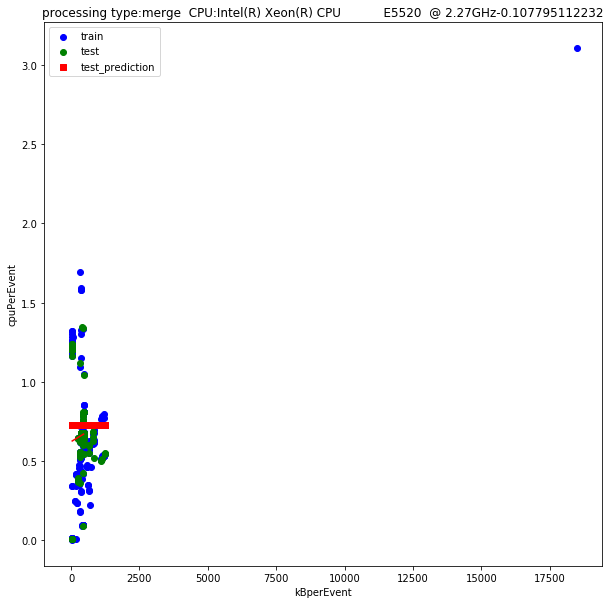

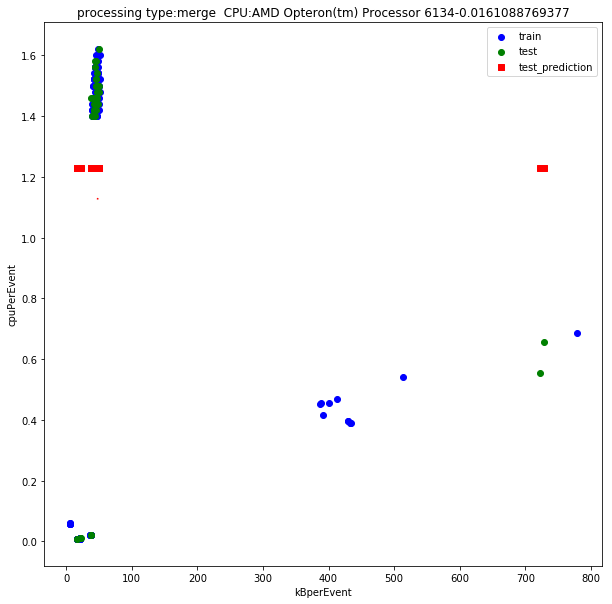

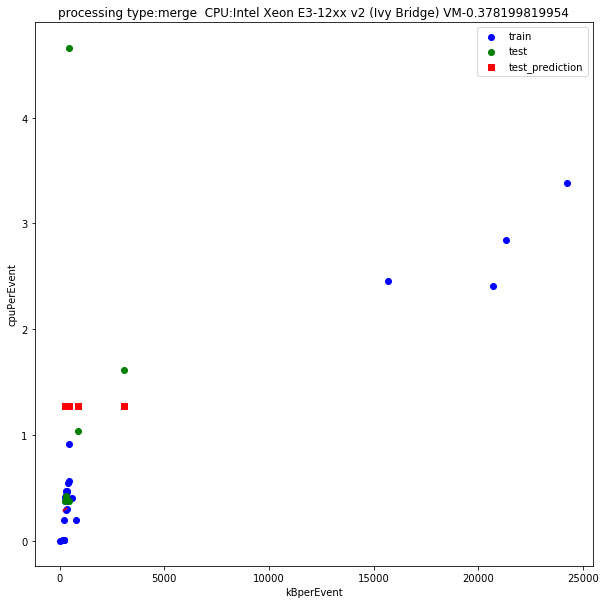

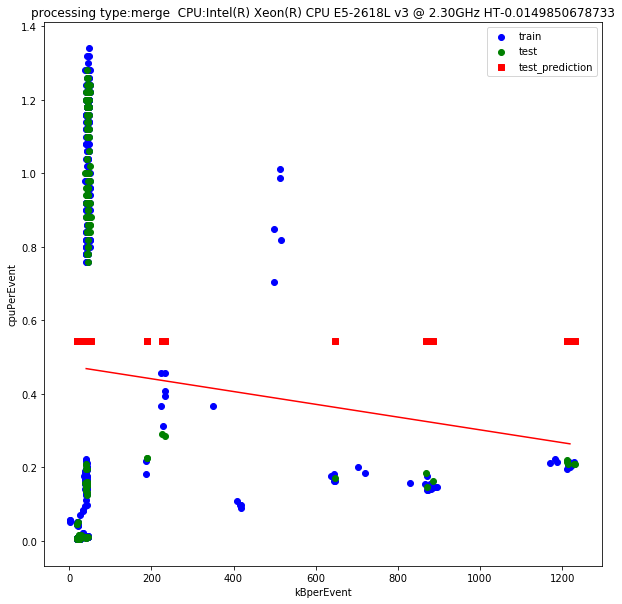

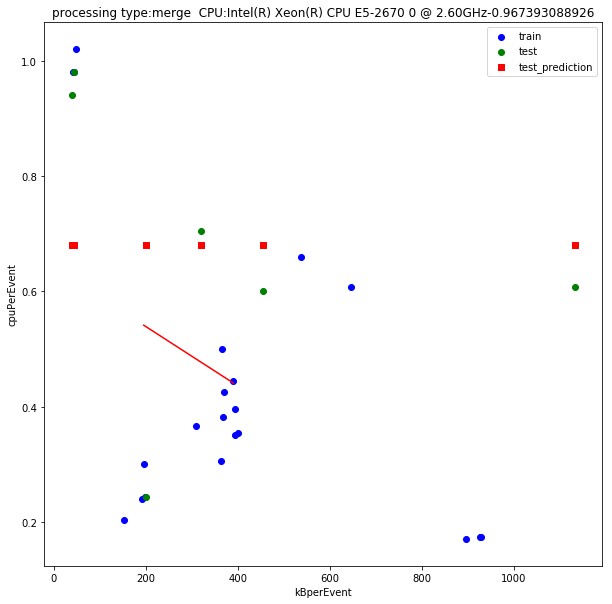

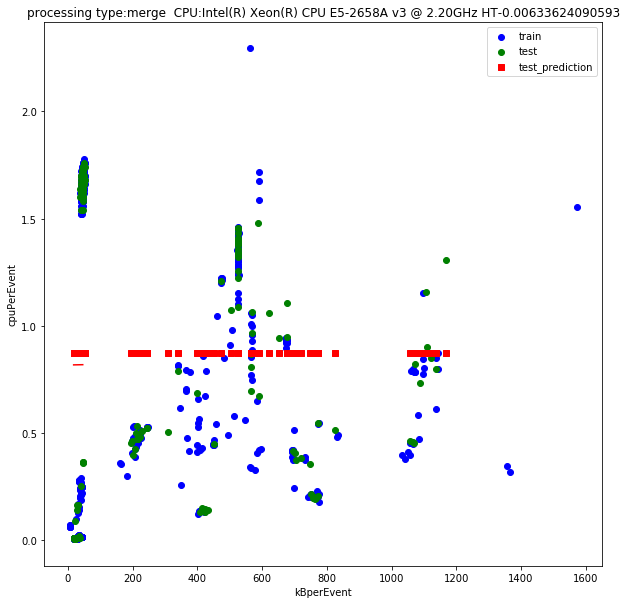

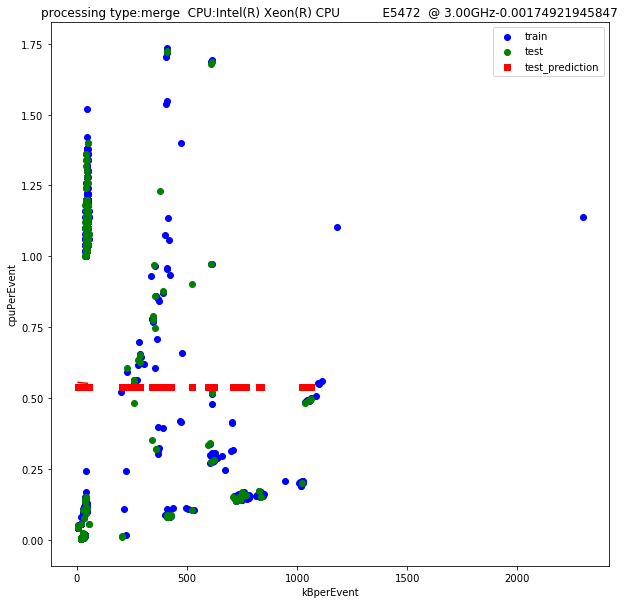

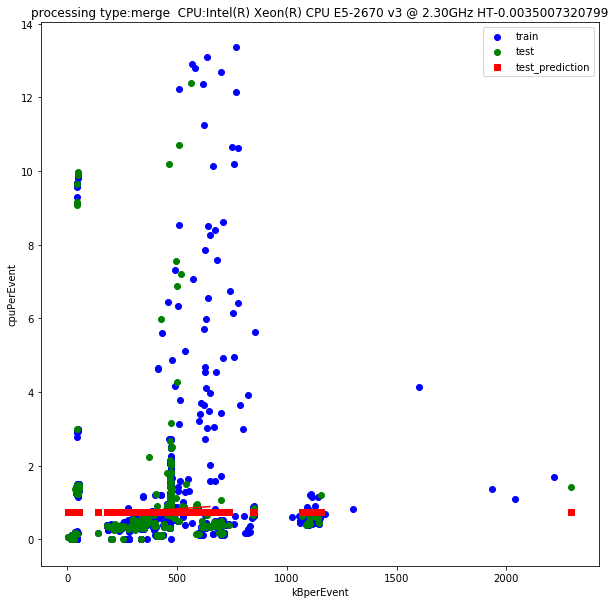

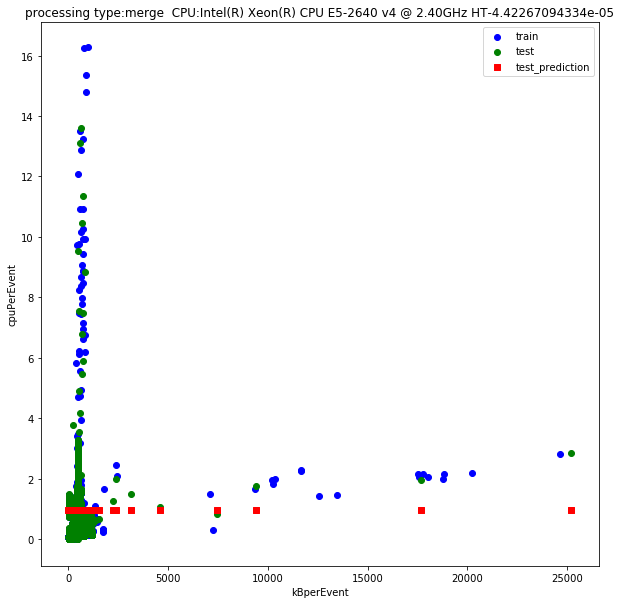

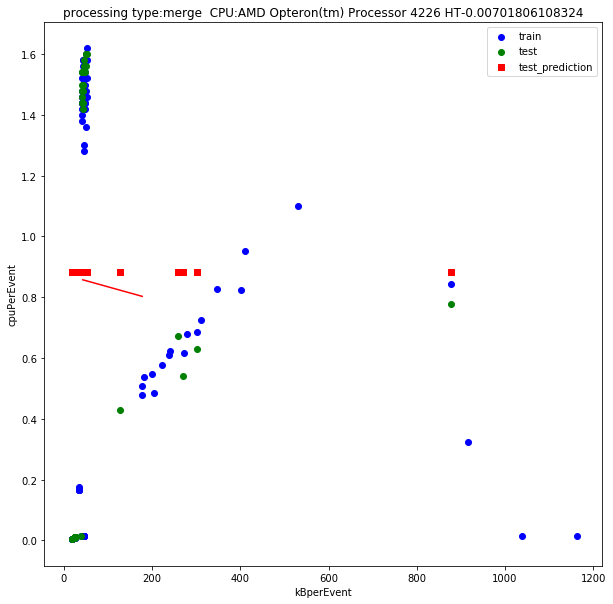

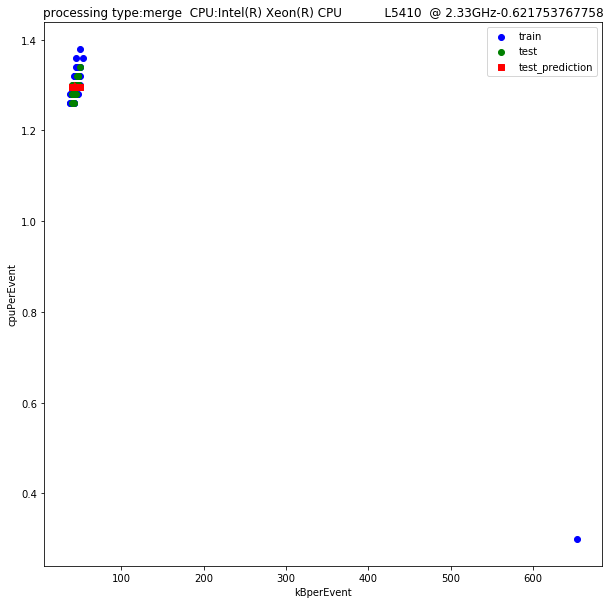

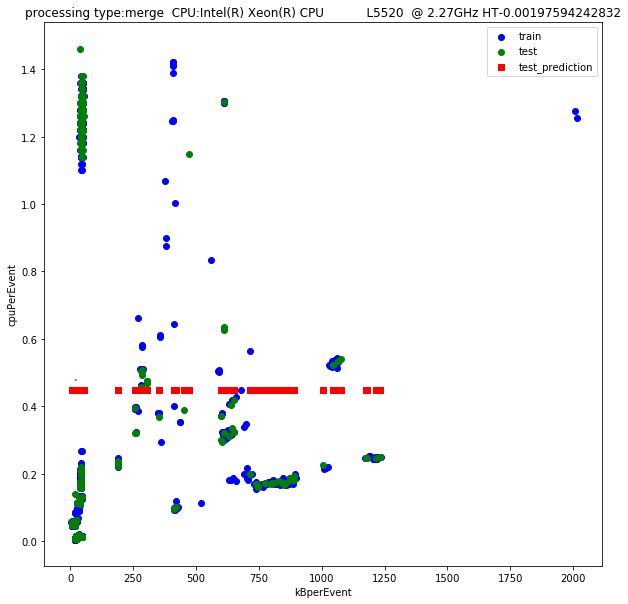

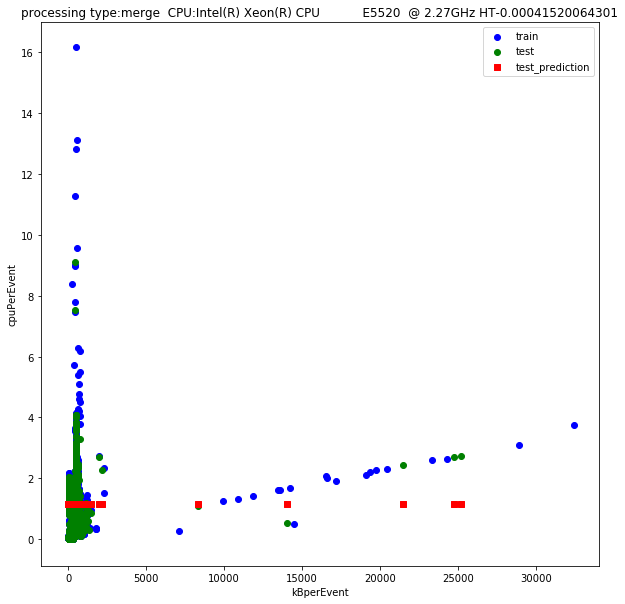

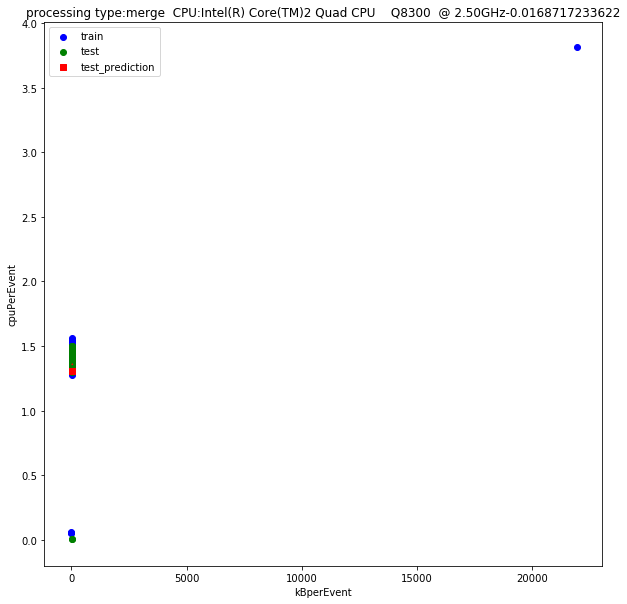

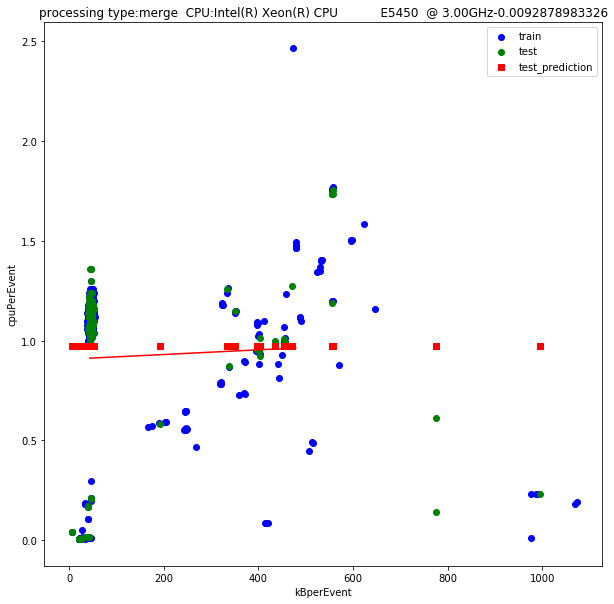

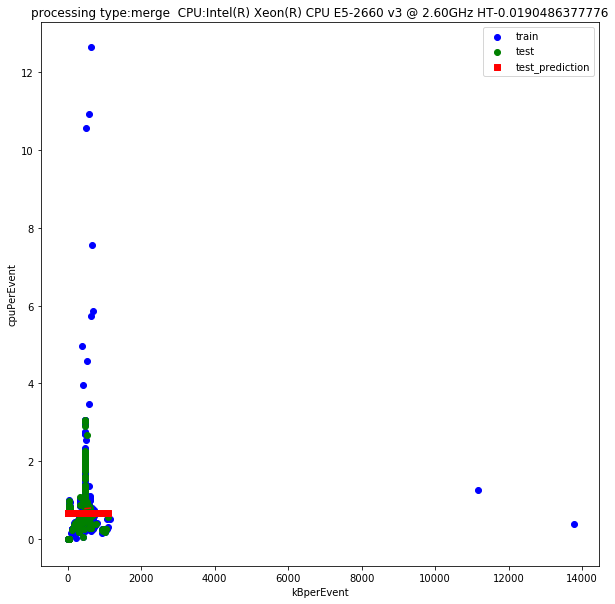

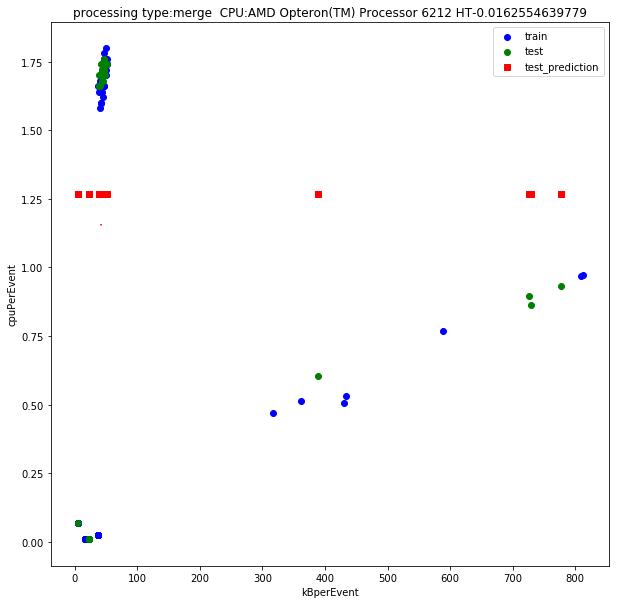

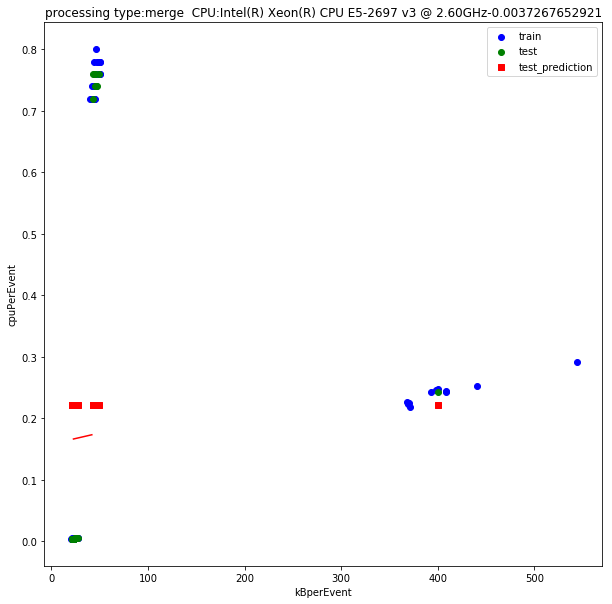

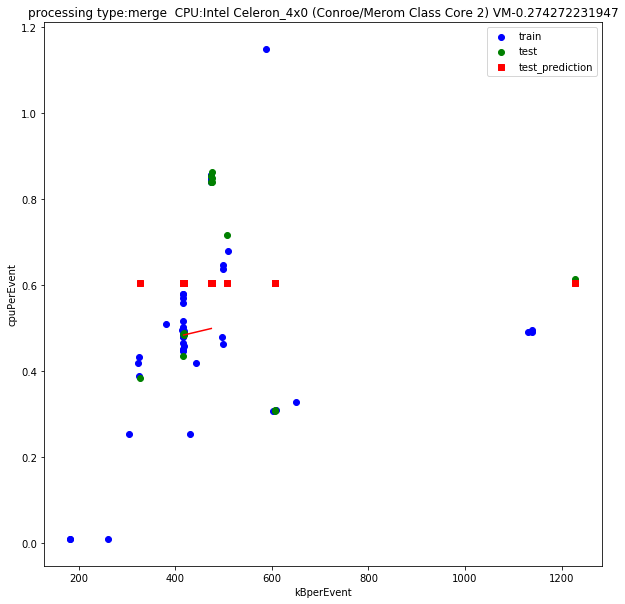

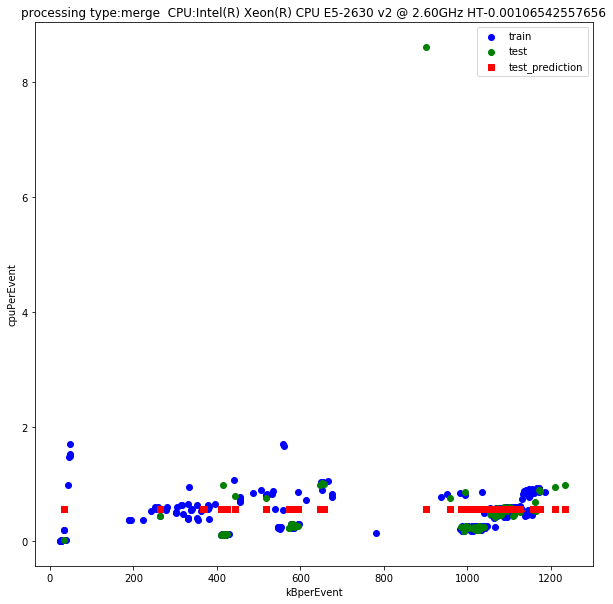

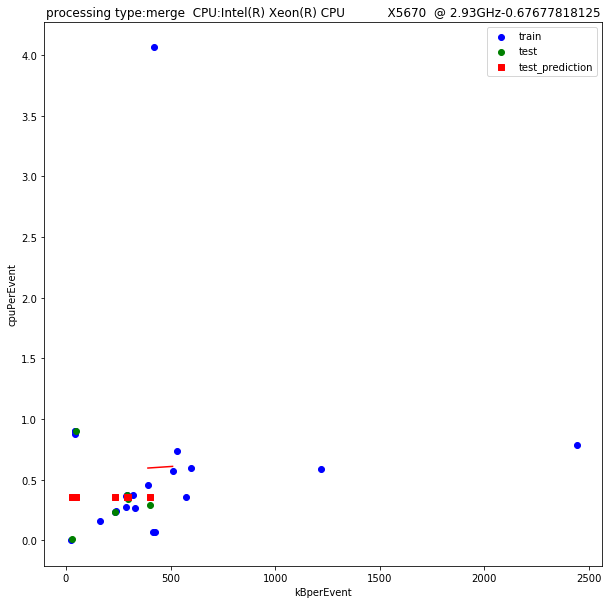

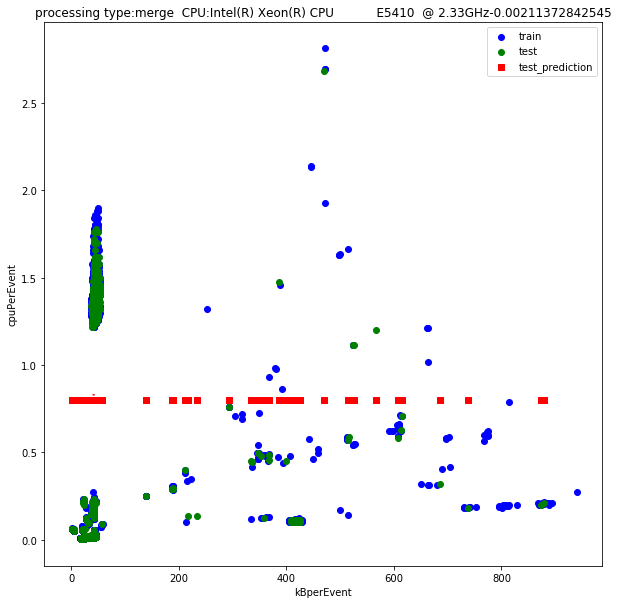

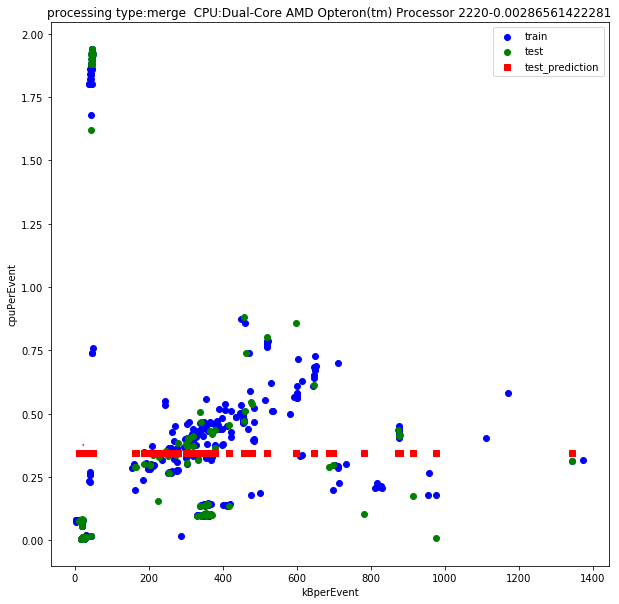

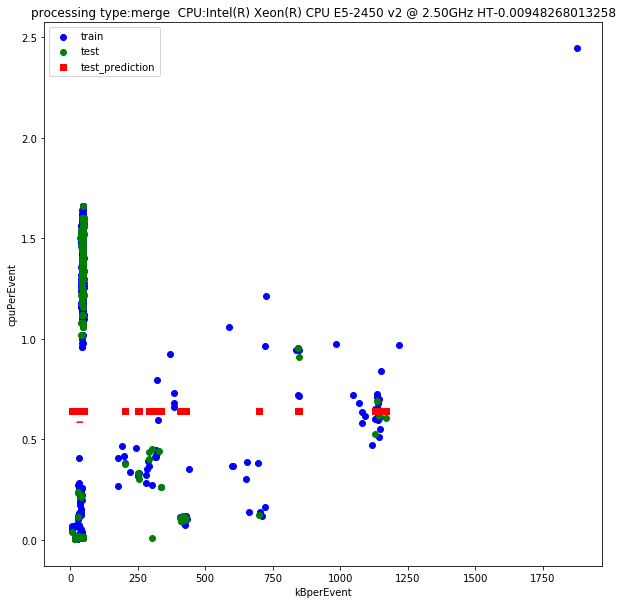

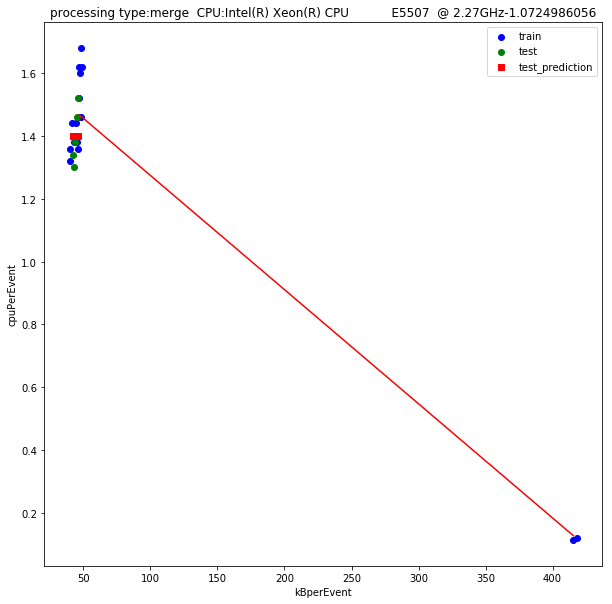

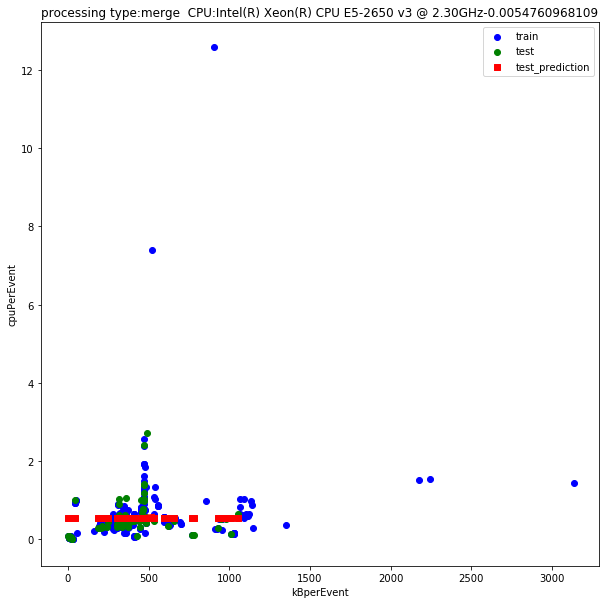

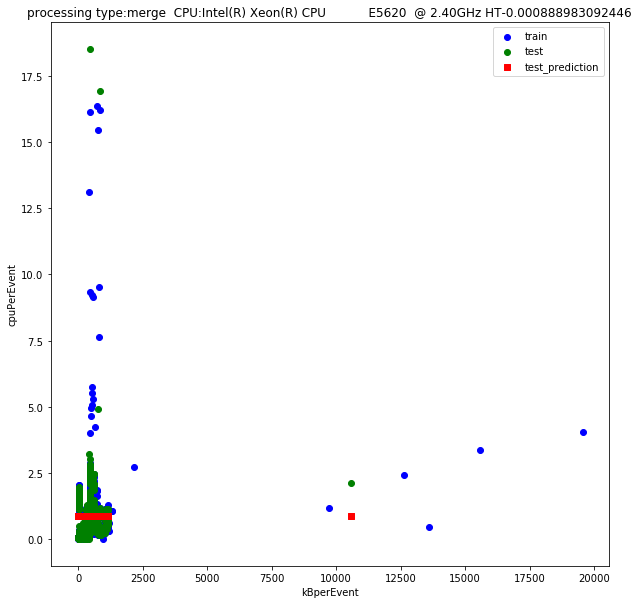

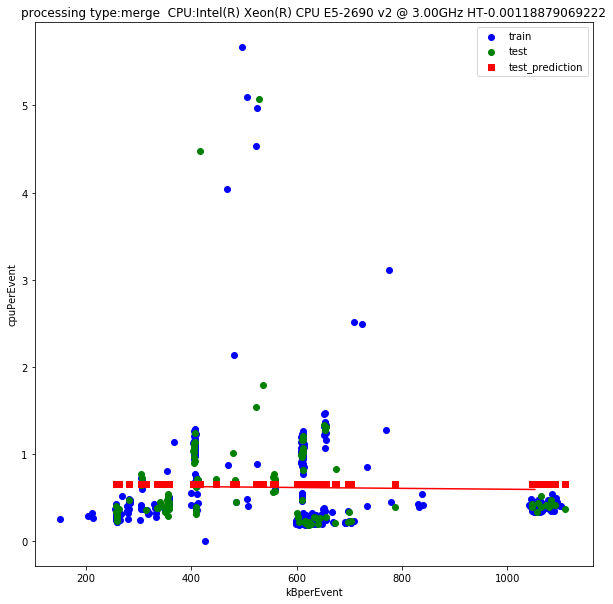

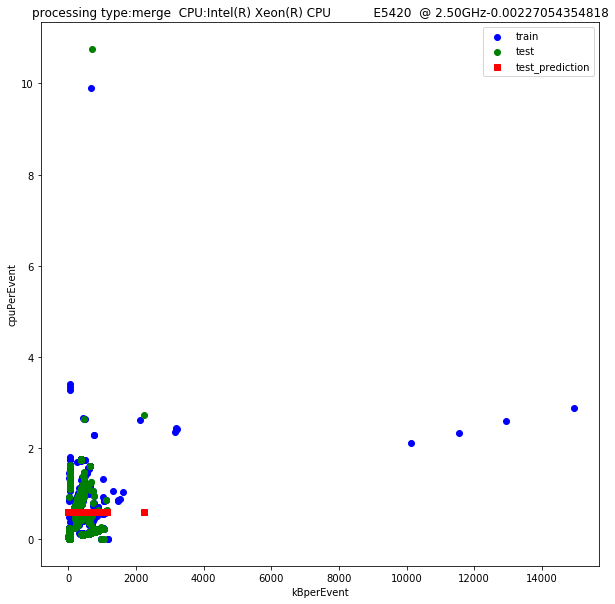

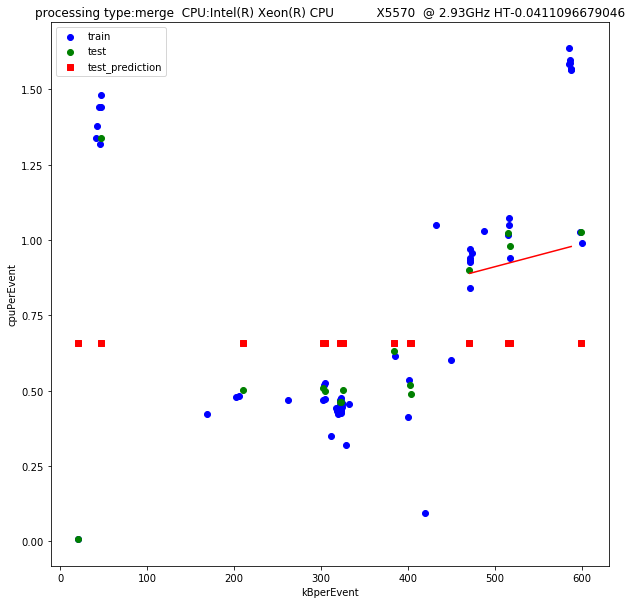

In [9]:
R_mse = {}
R_r2  = {}

for pt in ProcessingType:
    print("======================== ",pt,"==============================")
    
    if pt=="merge": 
        dbg = True
    else:
        dbg = False
        
    data = ProcessingType[pt]
    tmse=[]
    tr2=[]
    
    cdata = data.copy()
    del cdata['processingtype']
    
    UniqueCPUs = cdata.CPU.unique()
    #print(UniqueCPUs)
    UniqueCPUs=UniqueCPUs.tolist()
    
    #create a dict for all the dataframes to be filled later
    CPUtype = {elem : pd.DataFrame for elem in UniqueCPUs}

    #filling up data frames
    for key in CPUtype.keys():
        CPUtype[key] = cdata[:][cdata.CPU == key]
    
    allPred=[]
    allTrue=[]
    for CPU in CPUtype:
        print("-",CPU,"-")
        cpudata = CPUtype[CPU]
        
        y = cpudata['cpuPerEvent'].copy()
        y = y.values.reshape(-1, 1)
    
        del cpudata['cpuPerEvent']
        del cpudata['CPU']
    
        cpu_X_train,  cpu_X_test, cpu_y_train, cpu_y_test =  train_test_split( cpudata, y, test_size=0.20, random_state=41)
     #   print(cpu_X_train.shape, cpu_X_test.shape)
        
        Xtrain=cpu_X_train['kBperEvent'].values.reshape(-1, 1)
        Xtest=cpu_X_test['kBperEvent'].values.reshape(-1, 1)
        
        tr = cpu_y_test.flatten().tolist()
        allTrue += tr
        
        if cpu_X_train.shape[0]<10 or cpu_X_test.shape[0]<5:# or pt=="merge": 
            print('Not enough data. Using mean value.')
            pr=[cpu_y_test.flatten().mean()] * len(tr)
        else:
            # doing linear fit LReg or Ltsr
            lm = LReg.fit(Xtrain, cpu_y_train)
            # lm = Ltsr.fit(Xtrain, cpu_y_train)
            
            pr = lm.predict(Xtest).flatten().tolist()
            rsc = r2_score(tr, pr)
            if rsc<0:
                print("Bad fit, using mean. ", rsc, lm.coef_ , lm.intercept_ )
                pr = [cpu_y_test.flatten().mean()] * len(tr)
            else:
                print("good fit:",rsc)
            if dbg and rsc<0: 
                #print ("Linear model:",lm.coef_ , lm.intercept_)
                correlationPlot(
                        x1=Xtest.flatten().tolist(),
                        y1=tr,
                        x2=Xtest.flatten().tolist(),
                        y2=pr,
                        x3=Xtrain,
                        y3=cpu_y_train,
                        xt="kBperEvent",yt="cpuPerEvent",                             
                        tit="processing type:" + pt + "  CPU:" + CPU.strip() + str(rsc)
                        )
        
        allPred += pr
            
    evs = explained_variance_score(allTrue, allPred)
    mae = mean_absolute_error(allTrue, allPred)
    mse = mean_squared_error(allTrue, allPred)
    r2 = r2_score(allTrue, allPred) 
    print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
    
    tmse.append(mae)
    tr2.append(r2)
    
    R_mse[pt]=tmse
    R_r2[pt]=tr2

### plot results

In [10]:
Results=pd.DataFrame(R_r2,index=['cpu name'])
Results

,deriv,evgen,merge,pile,pmerge,recon,reprocessing,simul
cpu name,0.130008,0.18992,0.355826,0.812484,0.207493,0.224798,0.136427,0.152975


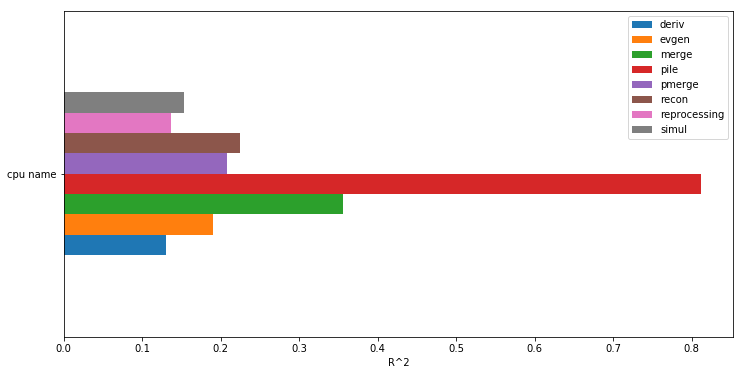

In [11]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.set_xlabel('R^2')
ax.get_figure().savefig("benchmarks_r2_"+LReg_name+"_no_constraints_CPU_only.png")

In [12]:
Results=pd.DataFrame(R_mse,index=['cpu name'])
Results

,deriv,evgen,merge,pile,pmerge,recon,reprocessing,simul
cpu name,0.431562,190.816868,0.392063,91.821118,0.158575,19.464993,5.100635,127.319503


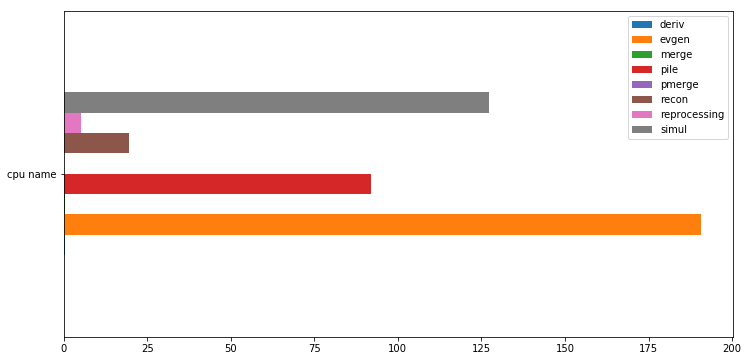

In [13]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks_mae_"+LReg_name+"_no_constraints_CPU_only.png")